# Visão Computacional - Lista 4

Aqui serão resolvidas as atividades da terceira lista de Visão Computacional pelo aluno Sillas Rocha da Costa, começaremos realizando alguns imports:

In [1]:
from matplotlib import pyplot as plt
import sounddevice as sd
import soundfile as sf
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# Exercício 1 - Áudio

Lendo o arquivo de áudio

In [2]:
data60, fs = sf.read("./StarWars60.wav", dtype='float32')
sd.play(data60, fs)
status = sd.wait()

Reduzindo para 10 segundos

In [3]:
seconds = 10
data10 = data60[:fs*seconds]
sd.play(data10, fs)
status = sd.wait()
write('./StarWars10.wav', fs, data10)

Plotando o resultado

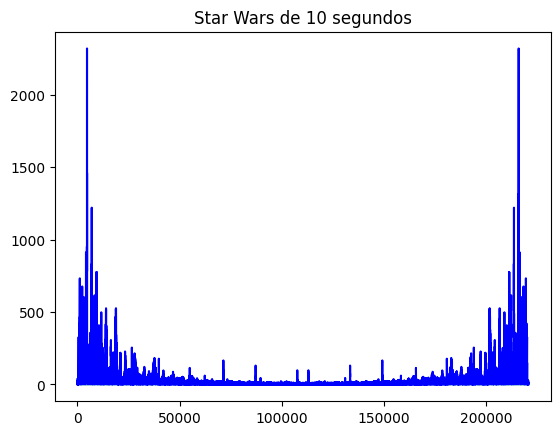

In [4]:
plt.plot(data10)
datahat = np.fft.fft(data10)
plt.plot(abs(datahat), color="blue")
plt.title("Star Wars de 10 segundos")
plt.show()

# Exercício 2 - Compressão com Fourier

In [5]:
p = 0.2
transfomada = np.fft.fft(data10)
freq_range = int(len(transfomada)*p)

transfomada[freq_range:-freq_range] = 0

data_results = np.fft.ifft(transfomada).real

# sd.play(data10, fs)
# status = sd.wait()
sd.play(data_results, fs)
status = sd.wait()

O som parece ficar mais abafado e com "menos nitidez" como se houvesse um colchão ou pano cobrindo o microfone na hora da gravação.

# Exercício 3 - Convolução em sinais de áudio com Fourier

a) Filtro com convolução:

In [6]:
def eco_normal(som:np.ndarray, fs:int, atraso:int=0.5) -> np.ndarray:
    range_atraso = int(fs*atraso)
    som_size = len(som)

    s_1 = np.zeros(range_atraso + som_size)
    s_2 = np.zeros(range_atraso + som_size)

    s_1[:som_size] = som
    s_2[range_atraso:] = som

    eco = s_1 + s_2/2

    return eco

def eco_convolve(som:np.ndarray, fs:int, atraso:int=0.5) -> np.ndarray:
    filtro = np.zeros_like(som)
    filtro[0] = 1
    filtro[int(atraso*fs)] = 1/2

    eco = np.fft.ifft(np.fft.fft(som) * np.fft.fft(filtro))

    return eco.real

In [7]:
audio, fs = sf.read("./Coruja.WAV", dtype='float32')  

audio_com_eco = eco_convolve(audio, fs)

sd.play(audio_com_eco, fs)
status = sd.wait()

b) Reverb:

In [8]:
def reverb_convolve(som:np.ndarray, fs:int, copias:int=10, atraso:float=0.1) -> np.ndarray:
    filtro = np.zeros_like(som)
    filtro[0] = 1

    range_atraso = int(fs*atraso)

    for i in range(1, copias+1):
        index = range_atraso * i

        filtro[index] = (copias-i+1)/(copias+1)


    eco = np.fft.ifft(np.fft.fft(som) * np.fft.fft(filtro))

    # print(filtro[filtro!=0])

    return eco.real

In [9]:
audio, fs = sf.read("./StarWars10.wav", dtype='float32')  

audio_com_eco = reverb_convolve(audio, fs)

sd.play(audio_com_eco, fs)
status = sd.wait()

# 4 - Compressão com Fourier e frequências altas com Fourier

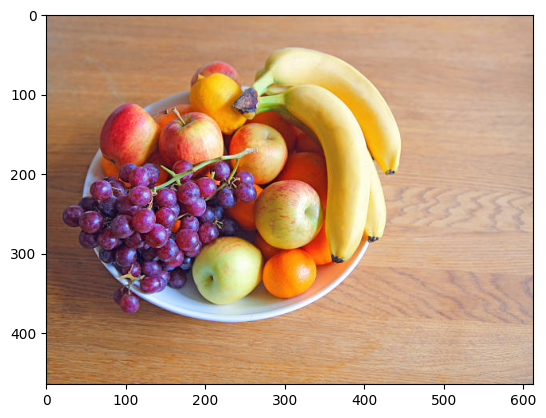

In [10]:
frutas = cv.imread("./frutas.jpg")
frutas = frutas[:,:,::-1]

plt.imshow(frutas)

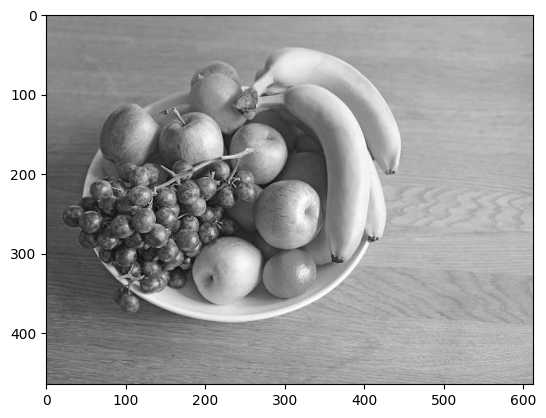

In [11]:
def para_p_e_b(img:np.ndarray) -> np.ndarray:
    
    p_e_b = np.mean(img, axis=2)
    
    for i in range(3):
        img[:,:,i] = p_e_b

    return img

frutas_pb = para_p_e_b(frutas)
plt.imshow(frutas_pb)

In [12]:
def compressao_fourier(img:np.ndarray, p:float, passa_alta:bool=False) -> np.ndarray:
    lins, cols = img.shape[:2]

    lin_center = int(lins/2)
    col_center = int(cols/2)

    lins_range = int((p * lins) / 2)
    cols_range = int((p * cols) / 2)

    img_fourier = np.fft.fft2(img[:,:,0])
    img_fourier_shifted = np.fft.fftshift(img_fourier)

    amostragem = np.zeros((lins, cols))

    amostragem[lin_center - lins_range:lin_center + lins_range,col_center - cols_range:col_center + cols_range] = 1
    if passa_alta:
        amostragem -= 1

    img_fourier_shifted = img_fourier_shifted * amostragem

    img_fourier_unshifted = np.fft.ifftshift(img_fourier_shifted)

    img_copy = np.zeros_like(img)

    for i in range(3):
        img_copy[:,:,i] = np.abs(np.fft.ifft2(img_fourier_unshifted))

    if np.max(img_copy) > 255:
        img_copy = np.clip(img_copy, 0, 255)
    
    return img_copy

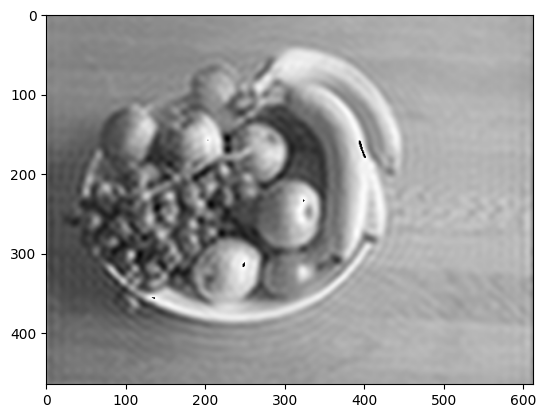

In [13]:
frutas_comprimida_b = compressao_fourier(frutas, 0.15)
plt.imshow(frutas_comprimida_b)
plt.show()

A qualidade da imagem é perdida e podem aparecer borrões na imagem

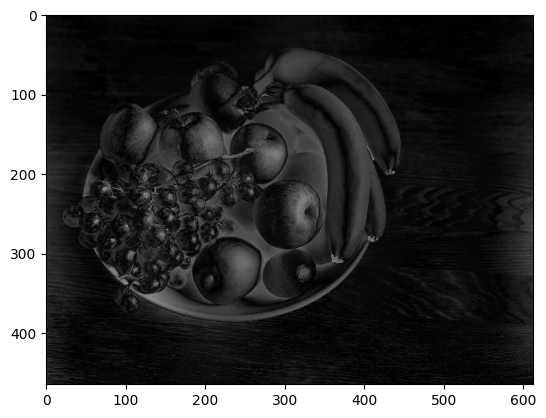

In [14]:
frutas_comprimida_a = compressao_fourier(frutas, 0.01, True)
plt.imshow(frutas_comprimida_a)
plt.show()

É um efeito semelhante a obter a imagem com as cores invertidas

# 5 - Convolução Circular

Como sabemos que uma convolução circular $T:\R^n\rightarrow\R^n$, leva o vetor $h\in\R^n$ com suas posições deslocadas de maneira equivalente as entradas do vetor de entradas, ao fazer $\delta=(1,0,0,...,0)$, será o equivalente a deslocar $h$ circularmente em $0$ posições e multiplicá-lo por $1$, já que é a primeira entrada do vetor $\delta, deste modo, obteremos o próprio $h$, de modo que $h=T(\delta)$

# 6 -  Invariante por translações

Suponha $h$ o filtro circular que corresponda a $F$, de modo que $F(u) = u\circledast h$, assim, obteremos que:
$$F(u(k-t)) = (u\circledast h)(k-t)$$
Mas como a convolução é linear:
$$F(u(k-t)) = u(k-t)\circledast h$$
Assim, concluimos que $F(u(k-t))$ é igual a convolução circular de $u(k-t)$ com $h$, deste modo, concluindo que $F$ é invariante por translação.

# 7.1 - Correção Automática de Gabaritos

In [15]:
def correcao_auto(gabarito:np.ndarray, respostas:np.ndarray) -> int:

    gabarito_fourier = np.fft.fft2(gabarito)
    respostas_fourier = np.fft.fft2(respostas)

    transformacao = gabarito_fourier/respostas_fourier

    respostas_corrigidas = respostas_fourier * transformacao


